In [1]:
import os
import shutil
import random

# Thư mục gốc dataset
root_dir = "/kaggle/input/vietnam-snake-new/VietNam_Snake_DataLast"
output_dir = "/kaggle/working/data"  # nơi lưu sau khi chia

# Tỉ lệ chia
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Tạo thư mục output
for split in ["train", "val", "test"]:
    split_dir = os.path.join(output_dir, split)
    os.makedirs(split_dir, exist_ok=True)

# Hàm lấy toàn bộ ảnh trong class (kể cả folder con)
def get_all_images_in_class(class_dir):
    image_files = []
    for root, dirs, files in os.walk(class_dir):
        for f in files:
            if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                image_files.append(os.path.join(root, f))
    return image_files

# Lặp qua từng class folder
for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)
    if not os.path.isdir(class_dir):
        continue

    images = get_all_images_in_class(class_dir)

    if len(images) == 0:
        print(f"⚠️ Class {class_name} không có ảnh, bỏ qua.")
        continue

    random.shuffle(images)

    n_total = len(images)
    n_train = int(train_ratio * n_total)
    n_val = int(val_ratio * n_total)
    n_test = n_total - n_train - n_val

    train_files = images[:n_train]
    val_files = images[n_train:n_train+n_val]
    test_files = images[n_train+n_val:]

    for split, split_files in zip(["train", "val", "test"], [train_files, val_files, test_files]):
        split_class_dir = os.path.join(output_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for src in split_files:
            dst = os.path.join(split_class_dir, os.path.basename(src))
            shutil.copy2(src, dst)

print("✅ Done! Dataset đã được chia vào thư mục '/kaggle/working/data/train', 'val', 'test'")


✅ Done! Dataset đã được chia vào thư mục '/kaggle/working/data/train', 'val', 'test'


In [2]:
import os
import hashlib
from collections import defaultdict

# Thư mục dataset
data_root = "/kaggle/working/data"

def file_hash(path):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            h.update(chunk)
    return h.hexdigest()

# 1. Tạo hash cho train
train_hashes = {}
for root, dirs, files in os.walk(os.path.join(data_root, "train")):
    for f in files:
        if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
            path = os.path.join(root, f)
            h = file_hash(path)
            train_hashes[h] = path  # chỉ giữ 1 path đại diện trong train

# 2. So sánh val/test với train
leak_dict = defaultdict(list)
for split in ["val", "test"]:
    split_dir = os.path.join(data_root, split)
    for root, dirs, files in os.walk(split_dir):
        for f in files:
            if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
                path = os.path.join(root, f)
                h = file_hash(path)
                if h in train_hashes:  # nếu hash trùng với ảnh train
                    leak_dict[h].append((train_hashes[h], path))

# 3. Báo cáo leak
print(f"🔎 Tổng số nhóm leak (val/test vs train): {len(leak_dict)}\n")

for h, pairs in leak_dict.items():
    print(f"--- Hash: {h} ---")
    for p in pairs:
        print(f"Train: {p[0]}")
        print(f"Leak : {p[1]}")
        print()

# 4. Xoá ảnh leak trong val/test
delete_count = 0
for h, pairs in leak_dict.items():
    for train_path, leak_path in pairs:
        try:
            os.remove(leak_path)
            delete_count += 1
            print(f"🗑️ Deleted leak: {leak_path}")
        except Exception as e:
            print(f"❌ Error deleting {leak_path}: {e}")

print(f"\n✅ Đã xoá {delete_count} ảnh leak khỏi val/test.\n")

# 5. Check lại sau khi xoá
leak_dict_check = defaultdict(list)
for split in ["val", "test"]:
    split_dir = os.path.join(data_root, split)
    for root, dirs, files in os.walk(split_dir):
        for f in files:
            if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
                path = os.path.join(root, f)
                h = file_hash(path)
                if h in train_hashes:
                    leak_dict_check[h].append((train_hashes[h], path))

print(f"🔎 Sau khi xoá, số nhóm leak còn lại: {len(leak_dict_check)}")


🔎 Tổng số nhóm leak (val/test vs train): 55

--- Hash: d63a3e4e5ea6d23ad255c2f68c8833a3 ---
Train: /kaggle/working/data/train/Calliophis_maculiceps/145415230_12.jpg
Leak : /kaggle/working/data/val/Calliophis_maculiceps/312381460_12.jpg

--- Hash: f758fbaa5c1bab6680f576e7903561cb ---
Train: /kaggle/working/data/train/Calliophis_maculiceps/312381460_3.jpg
Leak : /kaggle/working/data/val/Calliophis_maculiceps/145415230_3.jpg

--- Hash: 85a7311f06e44145b2f57d1b70102ccd ---
Train: /kaggle/working/data/train/Calliophis_maculiceps/312381460_2.jpg
Leak : /kaggle/working/data/val/Calliophis_maculiceps/145415230_2.jpg

--- Hash: e0545c9b117a735390e6867f1bc4c0db ---
Train: /kaggle/working/data/train/Myrrophis_chinensis/134960669_0.jpg
Leak : /kaggle/working/data/val/Myrrophis_chinensis/152713520_0.jpg

--- Hash: 8513c461154619f24d2b544e8e79cca4 ---
Train: /kaggle/working/data/train/Pareas_berdmorei/99958044_4.jpg
Leak : /kaggle/working/data/val/Pareas_berdmorei/99958044_0.jpg

--- Hash: 84dcc5669

In [29]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

In [30]:
# ======= Config =======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
epochs_phase1 = 5
epochs_phase2 = 20

In [31]:
# ======= Dataset Path =======
data_dir = "/kaggle/working/data"
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [32]:
# ======= Load datasets =======
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform_train)
val_dataset = datasets.ImageFolder(root=f"{data_dir}/val", transform=transform_val_test)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform_val_test)

class_names = train_dataset.classes
num_classes = len(class_names)
print("Số lớp:", num_classes)

Số lớp: 124


In [33]:
# ======= Dataloader =======
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [34]:
# ======= Model EfficientNetV2 =======
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

In [35]:
# ======= Eval =======
def evaluate(model, loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_sum += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return loss_sum / total, correct / total

In [36]:
# ======= History =======
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

# ======= Phase 1: Train chỉ Classifier =======
for name, param in model.named_parameters():
    if not name.startswith("classifier"):
        param.requires_grad = False

optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-3)

for epoch in range(epochs_phase1):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    val_loss, val_acc = evaluate(model, val_loader)

    # ✅ Lưu vào history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"[Phase1][Epoch {epoch+1}/{epochs_phase1}] "
          f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}  "
          f"Val Loss: {val_loss:.4f}  Val Acc: {val_acc:.4f}")

[Phase1][Epoch 1/5] Train Loss: 3.1363  Train Acc: 0.3055  Val Loss: 2.4399  Val Acc: 0.4146
[Phase1][Epoch 2/5] Train Loss: 2.2646  Train Acc: 0.4433  Val Loss: 2.1654  Val Acc: 0.4698
[Phase1][Epoch 3/5] Train Loss: 2.0132  Train Acc: 0.4843  Val Loss: 2.0349  Val Acc: 0.4869
[Phase1][Epoch 4/5] Train Loss: 1.8777  Train Acc: 0.5094  Val Loss: 1.9768  Val Acc: 0.4931
[Phase1][Epoch 5/5] Train Loss: 1.7905  Train Acc: 0.5264  Val Loss: 1.9021  Val Acc: 0.5157


In [37]:
# ======= Phase 2: Fine-tune toàn bộ model =======
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ======= Early Stopping Config =======
patience = 5  # số epoch cho phép không cải thiện
best_val_loss = float("inf")
no_improve_count = 0

for epoch in range(epochs_phase2):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    val_loss, val_acc = evaluate(model, val_loader)

    # ✅ Lưu vào history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"[Phase2][Epoch {epoch+1}/{epochs_phase2}] "
          f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}  "
          f"Val Loss: {val_loss:.4f}  Val Acc: {val_acc:.4f}")

    # ======= 🧠 Early Stopping =======
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_count = 0
        torch.save(model.state_dict(), "/kaggle/working/best_model.pth")  # lưu model tốt nhất
    else:
        no_improve_count += 1
        print(f"⚠️ Không cải thiện trong {no_improve_count} epoch.")

    if no_improve_count >= patience:
        print(f"⛔ Early stopping kích hoạt sau {patience} epoch không cải thiện.")
        break

[Phase2][Epoch 1/20] Train Loss: 0.8874  Train Acc: 0.7421  Val Loss: 0.6188  Val Acc: 0.8189
[Phase2][Epoch 2/20] Train Loss: 0.3543  Train Acc: 0.8923  Val Loss: 0.5007  Val Acc: 0.8559
[Phase2][Epoch 3/20] Train Loss: 0.1712  Train Acc: 0.9498  Val Loss: 0.5069  Val Acc: 0.8609
⚠️ Không cải thiện trong 1 epoch.
[Phase2][Epoch 4/20] Train Loss: 0.1130  Train Acc: 0.9681  Val Loss: 0.4669  Val Acc: 0.8730
[Phase2][Epoch 5/20] Train Loss: 0.0822  Train Acc: 0.9765  Val Loss: 0.4806  Val Acc: 0.8739
⚠️ Không cải thiện trong 1 epoch.
[Phase2][Epoch 6/20] Train Loss: 0.0677  Train Acc: 0.9811  Val Loss: 0.4936  Val Acc: 0.8743
⚠️ Không cải thiện trong 2 epoch.
[Phase2][Epoch 7/20] Train Loss: 0.0616  Train Acc: 0.9830  Val Loss: 0.5109  Val Acc: 0.8690
⚠️ Không cải thiện trong 3 epoch.
[Phase2][Epoch 8/20] Train Loss: 0.0604  Train Acc: 0.9824  Val Loss: 0.4979  Val Acc: 0.8739
⚠️ Không cải thiện trong 4 epoch.
[Phase2][Epoch 9/20] Train Loss: 0.0482  Train Acc: 0.9856  Val Loss: 0.5131  

In [ ]:
# ======= Lưu model =======
torch.save(model.state_dict(), "/kaggle/working/EfficientNetV2.pth")
print("✅ Đã lưu model tại /kaggle/working/EfficientNetV2.pth")

In [38]:
# ======= Test cuối =======
test_loss, test_acc = evaluate(model, test_loader)
print(f"🎯 Test Loss: {test_loss:.4f}  Test Acc: {test_acc:.4f}")

🎯 Test Loss: 0.4770  Test Acc: 0.8832


In [39]:
import numpy as np

def evaluate_per_class(model, loader, class_names):
    model.eval()
    correct_per_class = np.zeros(len(class_names))
    total_per_class = np.zeros(len(class_names))

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for label, pred in zip(labels, preds):
                total_per_class[label.item()] += 1
                if label == pred:
                    correct_per_class[label.item()] += 1

    print("\n=== Test Accuracy per Class ===")
    for i, cls in enumerate(class_names):
        acc = correct_per_class[i] / total_per_class[i] if total_per_class[i] > 0 else 0
        print(f"{cls:20s}: {acc*100:.2f}%  ({int(correct_per_class[i])}/{int(total_per_class[i])})")

In [41]:
# Đánh giá từng loài rắn
evaluate_per_class(model, test_loader, test_dataset.classes)


=== Test Accuracy per Class ===
Achalinus_rufescens : 100.00%  (13/13)
Achalinus_spinalis  : 85.71%  (12/14)
Acrochordus_granulatus: 95.35%  (41/43)
Acrochordus_javanicus: 87.50%  (7/8)
Ahaetulla_fusca     : 85.19%  (23/27)
Ahaetulla_prasina   : 85.00%  (17/20)
Ahaetulla_rufusoculara: 66.67%  (6/9)
Amphiesma_stolatum  : 80.26%  (61/76)
Blue-lipped_sea_krait: 92.68%  (76/82)
Boiga_cyanea        : 85.00%  (68/80)
Boiga_guangxiensis  : 50.00%  (4/8)
Boiga_jaspidea      : 92.68%  (38/41)
Boiga_kraepelini    : 77.61%  (52/67)
Boiga_multomaculata : 95.00%  (95/100)
Boiga_siamensis     : 90.32%  (28/31)
Bungarus_candidus   : 95.77%  (68/71)
Bungarus_fasciatus  : 97.70%  (85/87)
Calamaria_septentrionalis: 63.64%  (14/22)
Calliophis_maculiceps: 100.00%  (18/18)
Calloselasma_rhodostoma: 94.12%  (96/102)
Cerberus_schneiderii: 88.10%  (37/42)
Checkered_keelback  : 76.81%  (53/69)
Chrysopelea_ornata  : 95.52%  (64/67)
Coelognathus_flavolineatus: 90.00%  (27/30)
Coelognathus_radiatus: 94.25%  (82/8

In [43]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# =========================
# 7. Evaluation on Test Set
# =========================
# Load lại test dataset
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform_val_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Lấy mapping index -> class name
class_names = test_dataset.classes
num_classes = len(class_names)

# Load best model đã save
model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# =========================
# 8. Tính accuracy
# =========================
overall_acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {overall_acc:.4f}")

# =========================
# 9. Accuracy từng class
# =========================
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

print("\nAccuracy theo từng class:")
for i, class_name in enumerate(class_names):
    idx = (all_labels == i)
    if np.sum(idx) == 0:
        acc = 0.0
    else:
        acc = np.mean(all_preds[idx] == all_labels[idx])
    correct = np.sum(all_preds[idx] == all_labels[idx])
    total = np.sum(idx)
    print(f"{class_name:25s}  Acc: {acc:.4f}  ({correct}/{total})")

# =========================
# 10. Classification Report (optional)
# =========================
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))


Test Accuracy: 0.8785

Accuracy theo từng class:
Achalinus_rufescens        Acc: 1.0000  (13/13)
Achalinus_spinalis         Acc: 0.7857  (11/14)
Acrochordus_granulatus     Acc: 0.9535  (41/43)
Acrochordus_javanicus      Acc: 0.7500  (6/8)
Ahaetulla_fusca            Acc: 0.9259  (25/27)
Ahaetulla_prasina          Acc: 0.9000  (18/20)
Ahaetulla_rufusoculara     Acc: 1.0000  (9/9)
Amphiesma_stolatum         Acc: 0.8158  (62/76)
Blue-lipped_sea_krait      Acc: 0.9390  (77/82)
Boiga_cyanea               Acc: 0.8750  (70/80)
Boiga_guangxiensis         Acc: 0.7500  (6/8)
Boiga_jaspidea             Acc: 1.0000  (41/41)
Boiga_kraepelini           Acc: 0.8209  (55/67)
Boiga_multomaculata        Acc: 0.9700  (97/100)
Boiga_siamensis            Acc: 0.6774  (21/31)
Bungarus_candidus          Acc: 0.9296  (66/71)
Bungarus_fasciatus         Acc: 0.9770  (85/87)
Calamaria_septentrionalis  Acc: 0.8182  (18/22)
Calliophis_maculiceps      Acc: 0.9444  (17/18)
Calloselasma_rhodostoma    Acc: 0.9314  (95

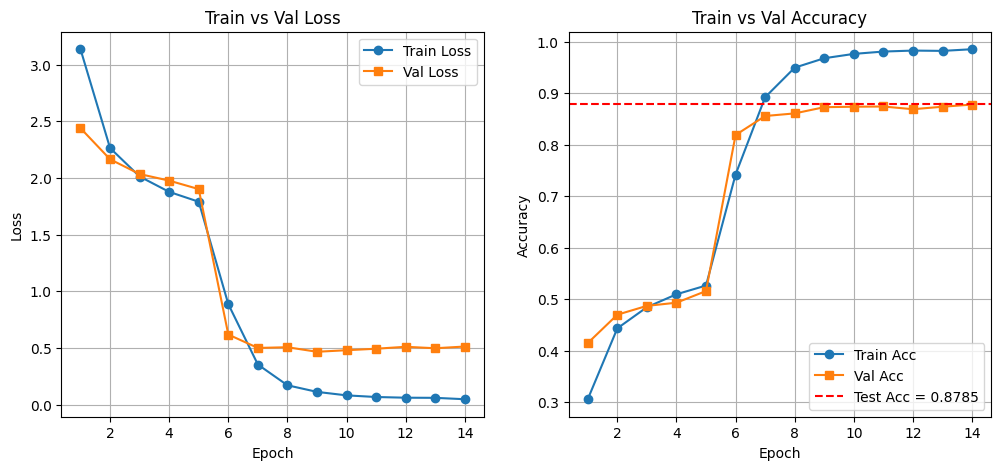

In [46]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], 'o-', label="Train Loss")
plt.plot(epochs, history["val_loss"], 's-', label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, history["train_acc"], 'o-', label="Train Acc")
plt.plot(epochs, history["val_acc"], 's-', label="Val Acc")
plt.axhline(y=overall_acc, color='r', linestyle='--', label=f"Test Acc = {overall_acc:.4f}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Val Accuracy")
plt.legend()
plt.grid(True)

plt.show()
